In [32]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests 

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
df = pd.read_csv('ab_browser_test.csv')
df

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30
...,...,...,...,...,...,...
566129,603133,Browser #14,control,1,2,1
566130,603134,Browser #2,exp,4,2,0
566131,603135,Browser #4,control,0,1,1
566132,603136,Browser #4,control,2,3,1


Описание данных:
* userID: уникальный идентификатор пользователя
* browser: браузер, который использовал userID
* slot: в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control = видел неизменную страницу)
* n_clicks: количество кликов, которые пользоваль совершил за n_queries
* n_queries: количество запросов, который совершил userID, пользуясь браузером browser
* n_nonclk_queries: количество запросов пользователя, в которых им не было совершено ни одного клика


Обращаем ваше внимание, что не все люди используют только один браузер, поэтому в столбце userID есть повторяющиеся идентификаторы. В предлагаемых данных уникальным является сочетание userID и browser.


Основная метрика, на которой мы сосредоточимся в этой работе, — это количество пользовательских кликов на web-странице в зависимости от тестируемого изменения этой страницы.

Посчитайте, насколько в группе exp больше пользовательских кликов по сравнению с группой control в процентах от числа кликов в контрольной группе.

Полученный процент округлите до третьего знака после точки.

In [14]:
groups = df.groupby(['slot']).agg({'n_clicks':'sum', 'n_queries': 'sum', 'n_nonclk_queries':'sum'})
exp_clicks = groups['n_clicks']['exp']
control_clicks = groups['n_clicks']['control']
print("в группе exp больше пользовательских кликов: {}".format(exp_clicks / control_clicks * 100 - 100))

в группе exp больше пользовательских кликов: 1.6135689824415778


Давайте попробуем посмотреть более внимательно на разницу между двумя группами (control и exp) относительно количества пользовательских кликов.

Для этого постройте с помощью бутстрепа 95% доверительный интервал для средних значений и медиан количества кликов в каждой из двух групп. Отметьте все верные утверждения.

In [30]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

np.random.seed(0)

exp_clicks_bootstrap_mean = np.array(list(map(np.mean, get_bootstrap_samples(df[df['slot'] == 'exp'].n_clicks.values, 100))))
control_clicks_bootstrap_mean = np.array(list(map(np.mean, get_bootstrap_samples(df[df['slot'] == 'control'].n_clicks.values, 100))))

exp_clicks_bootstrap_median = np.array(list(map(np.median, get_bootstrap_samples(df[df['slot'] == 'exp'].n_clicks.values, 100))))
control_clicks_bootstrap_median = np.array(list(map(np.median, get_bootstrap_samples(df[df['slot'] == 'control'].n_clicks.values, 100))))


mean_clicks_dif = exp_clicks_bootstrap_mean - control_clicks_bootstrap_mean
mean_int = stat_intervals(mean_clicks_dif, 0.05)

median_clicks_dif = exp_clicks_bootstrap_median - control_clicks_bootstrap_median
median_int = stat_intervals(median_clicks_dif, 0.05)



print('95пц интервал среднего: [%f, %f]' 
      % (mean_int[0], mean_int[1]))
print('95пц интервал медианы: [%f, %f]' 
      % (median_int[0], median_int[1]))

95пц интервал среднего: [0.206968, 0.394413]
95пц интервал медианы: [1.000000, 1.000000]


1. 95% доверительный интервал для разности медиан не содержит ноль, похоже, медианы отличаются статистически значимо
2. Применение bootstrap на выборках такого большого размера неправомерно, потому что bootstrap делает псведовыборки с возвращениями, а с ростом объема исходной выборки псведовыборки с возвращениями становятся более похожими на псведовыборки без возвращения.
3. 95% доверительный интервал для разности средних содержит ноль, похоже, средние существенно не отличаются
4. 95% доверительный интервал для разности медиан содержит ноль, похоже, медианы существенно не отличаются
5. 95% доверительный интервал для разности средних не содержит ноль, похоже, средние отличаются статистически значимо.


Answer: 1, 5

Поскольку данных достаточно много (порядка полумиллиона уникальных пользователей), отличие в несколько процентов может быть не только практически значимым, но и значимым статистически. Последнее утверждение нуждается в дополнительной проверке.

Посмотрите на выданные вам данные и выберите все верные варианты ответа относительно проверки гипотезы о равенстве среднего количества кликов в группах.


1. Гипотезу о равенстве средних между двумя выборками можно проверить с помощью построения доверительного интервала для среднего объединенной выборки, потому что в силу большого объема выборки этот интервал будет очень точным, и мы сможем надежно оценить необходимый доверительный интервал
2. - Все ответы неверны
3. Для проверки гипотезы о равенстве средних в данной задаче можно использовать только параметрические критерии, потому что непараметрические, как известно, с увеличением размера выборки могут давать непредсказуемые результаты в силу случайности в определении их нулевого распределения.
4. - Для проверки гипотезы о равенстве средних категорически нельзя использовать t-критерий Стьюдента ни при каком размере выборки, потому что количество кликов, которые мы исследуем, больше походят на распределение Пуассона, которое сильно отличается от нормального.
5. Используя центральную предельную теорему, мы можем заключить, что с ростом объема выборки любое исследуемое распределение, становится похожим на нормальное, а значит, учитывая большой объем нашей выборки, оптимальным критерием в нашей задаче будет z-критерий.

Answer: 1, 5


t-критерий Стьюдента имеет множество достоинств, и потому его достаточно часто применяют в AB экспериментах. Иногда его применение может быть необоснованно из-за сильной скошенности распределения данных.

Давайте постараемся понять, когда t-критерий можно применять и как это проверить на реальных данных.

Поскольку мы не знаем истинного распределения генеральной совокупности, мы можем применить бутстреп, чтобы понять, как распределены среднее значение и выборочная дисперсия. Для этого

Получите из данных n_boot_samples псевдовыборок.
По каждой из этих выборок посчитайте среднее и сумму квадратов отклонения от выборочного среднего (control_boot_chi_squared)
Для получившегося вектора средних значений из n_boot_samples постройте q-q plot с помощью scipy.stats.probplot для нормального распределения
Для получившегося вектора сумм квадратов отклонения от выборочного среднего постройте qq-plot с помощью scipy.stats.probplot для хи-квадрат распределения с помощью команды

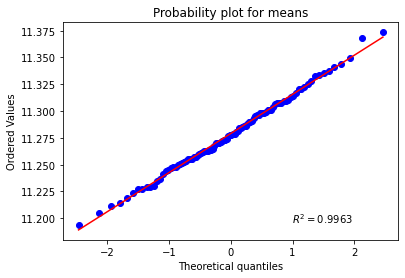

In [34]:
#probability plot for means
_ = stats.probplot(control_clicks_bootstrap_mean, plot=plt, rvalue=True)
_ = plt.title('Probability plot for means')

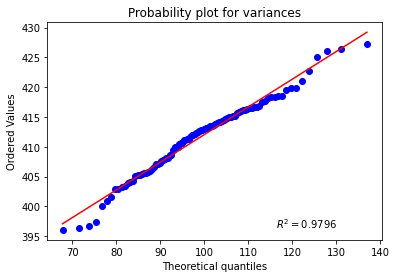

In [37]:
#probability plot for variances
control_click_bootstrap_var = np.array(list(map(np.var, get_bootstrap_samples(df[df['slot'] == 'control'].n_clicks.values, 100))))


_ = stats.probplot(control_click_bootstrap_var, plot=plt, dist='chi2', sparams=(control_clicks_bootstrap_mean.shape[0]-1), rvalue=True)
_ = plt.title('Probability plot for variances')

Одним из возможных аналогов t-критерия, которым можно воспрользоваться, является тест Манна-Уитни. На достаточно обширном классе распределений он является асимптотически более эффективным, чем t-критерий, и при этом не требует параметрических предположений о характере распределения.

Разделите выборку на две части, соответствующие control и exp группам. Преобразуйте данные к виду, чтобы каждому пользователю соответствовало суммарное значение его кликов. С помощью критерия Манна-Уитни проверьте гипотезу о равенстве средних. Что можно сказать о получившемся значении достигаемого уровня значимости ? Выберите все правильные ответы

In [42]:
exp = df.slot.loc[df.slot == 'exp'].index
ctrl = df.slot.loc[df.slot == 'control'].index

users_nclicks_exp = df.loc[exp].groupby(['userID', 'browser']).sum().loc[:,'n_clicks']
users_nclicks_ctrl = df.loc[ctrl].groupby(['userID', 'browser']).sum().loc[:,'n_clicks']

users_nclicks_exp.head()
users_nclicks_ctrl.head()
stats.mannwhitneyu(users_nclicks_exp, users_nclicks_ctrl, alternative='two-sided')

userID  browser   
1       Browser #2    23
3       Browser #4     3
5       Browser #4    29
7       Browser #4    54
9       Browser #4     6
Name: n_clicks, dtype: int64

userID  browser    
6       Browser #4     12
8       Browser #4      4
10      Browser #4     22
15      Browser #14     2
23      Browser #4      3
Name: n_clicks, dtype: int64

MannwhitneyuResult(statistic=41184125116.0, pvalue=6.247235801369629e-75)

Проверьте, для какого из браузеров наиболее сильно выражено отличие между количеством кликов в контрольной и экспериментальной группах.

Для этого примените для каждого из срезов (по каждому из уникальных значений столбца browser) критерий Манна-Уитни между control и exp группами и сделайте поправку Холма-Бонферрони на множественную проверку с \alpha=0.05α=0.05.

Какое заключение можно сделать исходя из полученных результатов ?

В качестве ответа введите количество незначимых изменений с точки зрения результатов, полученных после введения коррекции.

In [49]:
browsers_nclicks_exp = df.loc[exp].groupby(['browser', 'userID']).sum().loc[:,'n_clicks']
browsers_nclicks_ctrl = df.loc[ctrl].groupby(['browser', 'userID']).sum().loc[:,'n_clicks']

browsers_nclicks_exp.head()
browsers_nclicks_ctrl.head()

browsers = np.unique(df.browser)
print('Unique browsers numbers: ' + str(browsers))
print('')

print('Mann-Whitney rank test without multipletest')
mw_p = np.empty(browsers.shape[0])
for i, br in enumerate(browsers):
    print('Browser {}: '.format(br) ),
    _, mw_p[i] = stats.mannwhitneyu(browsers_nclicks_exp.loc[br, :], browsers_nclicks_ctrl.loc[br, :], alternative='two-sided')
    print('p-value = %.4f' % mw_p[i])

print('')
print('Mann-Whitney rank test with multipletest')
_, mw_p_corr, _, _ = multipletests(mw_p, alpha = 0.05, method = 'holm')
for i, br in enumerate(browsers):
    print('Browser {}: '.format(br) ),
    print('p-value = %.4f' % mw_p_corr[i])

browser      userID
Browser #14  13         2
             30         4
             33        22
             45         5
             83         0
Name: n_clicks, dtype: int64

browser      userID
Browser #14  15        2
             39        0
             56        4
             81        2
             88        2
Name: n_clicks, dtype: int64

Unique browsers numbers: ['Browser #14' 'Browser #17' 'Browser #2' 'Browser #20' 'Browser #22'
 'Browser #4']

Mann-Whitney rank test without multipletest
Browser Browser #14: 


(None,)

p-value = 0.0000
Browser Browser #17: 


(None,)

p-value = 0.0748
Browser Browser #2: 


(None,)

p-value = 0.0545
Browser Browser #20: 


(None,)

p-value = 0.9073
Browser Browser #22: 


(None,)

p-value = 0.5148
Browser Browser #4: 


(None,)

p-value = 0.8152

Mann-Whitney rank test with multipletest
Browser 0: 


(None,)

p-value = 0.0000
Browser 1: 


(None,)

p-value = 0.2992
Browser 2: 


(None,)

p-value = 0.2724
Browser 3: 


(None,)

p-value = 1.0000
Browser 4: 


(None,)

p-value = 1.0000
Browser 5: 


(None,)

p-value = 1.0000


Для каждого браузера в каждой из двух групп (control и exp) посчитаем долю запросов, в которых пользователь не кликнул ни разу. Это можно сделать, поделив сумму значений n_nonclk_queries на сумму значений n_queries. Умножив это значение на 100, получим процент некликнутых запросов, который можно легче проинтерпретировать.

In [48]:
browsers_nonclk_q_exp = df.loc[exp].groupby(['browser']).sum().loc[:,'n_nonclk_queries']
browsers_clk_q_exp = df.loc[exp].groupby(['browser']).sum().loc[:,'n_queries']
browsers_nonclk_q_prop_exp = browsers_nonclk_q_exp / browsers_clk_q_exp

browsers_nonclk_q_ctrl = df.loc[ctrl].groupby(['browser']).sum().loc[:,'n_nonclk_queries']
browsers_clk_q_ctrl = df.loc[ctrl].groupby(['browser']).sum().loc[:,'n_queries']
browsers_nonclk_q_prop_ctrl = browsers_nonclk_q_ctrl / browsers_clk_q_ctrl

print('Control / experimental groups')
for br in browsers:
    print('Browser {}: '.format(br) ),
    print(browsers_nonclk_q_prop_ctrl.loc[browsers_nonclk_q_prop_ctrl.index == br].values),
    print('/'),
    print(browsers_nonclk_q_prop_exp.loc[browsers_nonclk_q_prop_ctrl.index == br].values)

Control / experimental groups
Browser Browser #14: 


(None,)

[0.57590411]


(None,)

/


(None,)

[0.43755617]
Browser Browser #17: 


(None,)

[0.36299367]


(None,)

/


(None,)

[0.36937413]
Browser Browser #2: 


(None,)

[0.45962747]


(None,)

/


(None,)

[0.44982747]
Browser Browser #20: 


(None,)

[0.40540485]


(None,)

/


(None,)

[0.38977376]
Browser Browser #22: 


(None,)

[0.40593977]


(None,)

/


(None,)

[0.39853947]
Browser Browser #4: 


(None,)

[0.4697093]


(None,)

/


(None,)

[0.45142942]
